## Analysis_Waterloo-Part2 

We will continue our research by analyzing the standard feature - **maximum quality level ratio (Ph)**. It is believed that if the highest quality level is reproduced, the user is more satisfied.

That is, for example, you are watching YouTube. And you have 360/480/720/1080 options. And if you look outside 1080, you will be a little disappointed.

What do you think about this?

The research below shows that things are a little more complicated. I'll tell you right away that the answer depends on the size of the screen. But there are no mobile devices in the SKoE3 dataset. The higher the quality, the more likely buffering and re-buffering delays are likely to spoil your viewing.
In addition, the difference between high quality videos is not always visible.

In [1]:
import scipy.io

import pandas as pd
import numpy as np
import statistics

import math
import seaborn as sns

import statistics

import re 
from scipy.stats import spearmanr

from platform import python_version
print(python_version())

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

from itertools import combinations_with_replacement, combinations

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

from scipy.stats.stats import pearsonr, kendalltau, spearmanr

3.7.4


In [2]:
full = pd.read_pickle("Part1_tmp")

In [3]:
full.head(1)

,Name,FPS,stallTime,duration,switching,SwithcingMagnitide,bitrates,seqPSNR per frame,initial buffer time,duration of stalling events in second,...,freq_of_st,Bitrate switch count,freq_of_sw,median(bitrates),Rebuffer percentage,dash_change_count,Average Bitrate Swithcing magnitude,Average relative Bitrate Swithcing magnitude,Ratio on highest sequense quality layer,Ratio on highest sequense quality layer1
0,BigBuckBunny,30,4.0333,14.0333,[false. false. false. false],0,"[222.0, 222.0, 222.0, 222.0, 222.0]","[23.2066, 23.1989, 23.1793, 23.1564, 23.1283, ...",1.8,"[0.73333, 1.0667, 0.43333]",...,0.213777,0.0,0.0,222.0,0.182559,0.0,0.0,0.0,0.817441,0.817441


In [4]:
def Ph(bitrates, duration, inbuf):
    max_bitrate = max (bitrates)
    highest_quality_dutarion = bitrates.count(max_bitrate)
    ph = 2*highest_quality_dutarion / (duration-inbuf)
    
    return ph

SpearmanrResult(correlation=0.17757416164459214, pvalue=0.0001527381644023074)


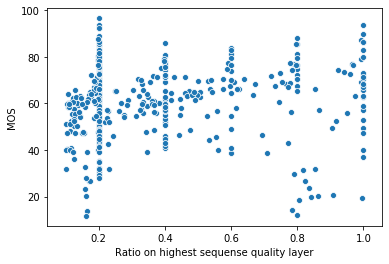

In [5]:
full["Ratio on highest sequense quality layer"] = np.nan
for index, row in full.iterrows():
    value = Ph(row['bitrates'], row['duration'], row['initial buffer time'])
    full.at[index, 'Ratio on highest sequense quality layer'] = value

sns.scatterplot(y="MOS", x="Ratio on highest sequense quality layer", ci=None, data=full)
print(spearmanr(full['MOS'], full['Ratio on highest sequense quality layer']))

Let's consider how the **minimum quality ratio** affects QoE. The minimum quality is calculated **per session**. In fact, this is an assessment of the impact of quality failures. Well, practically does not affect

In [6]:
def Ph_min(bitrates, duration, inbuf):
    min_bitrate = min (bitrates)
    min_quality_dutarion = bitrates.count(min_bitrate)
    ph = 2*min_quality_dutarion / (duration-inbuf)
    return ph

SpearmanrResult(correlation=-0.008188241824241254, pvalue=0.8624795812029498)


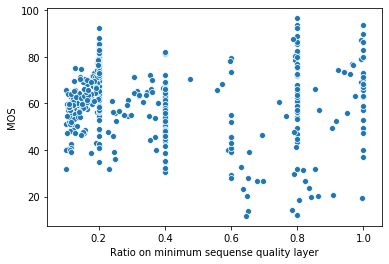

In [7]:
full["Ratio on minimum sequense quality layer"] = np.nan
for index, row in full.iterrows():
    value = Ph_min(row['bitrates'], row['duration'], row['initial buffer time'])
    full.at[index, 'Ratio on minimum sequense quality layer'] = value

sns.scatterplot(y="MOS", x="Ratio on minimum sequense quality layer", ci=None, data=full)
print(spearmanr(full['MOS'], full['Ratio on minimum sequense quality layer']))

Let's consider how the minimum quality ratio affects QoE. The maximum quality is calculated from a list of all coding levels.

As you can see, there are not many sessions where 7000 kbps was during the entire session.

In [8]:
#DASH Bitrates leveks
dash_list = [235, 375, 560, 750, 1050, 1750,2350,3000,4300,5800,7000]

In [9]:
def maxRatio (bitrates, level, duration, inbuf):
    bitrates = [int(item) for item in bitrates]
    max_bitrate = max (bitrates)
    highest_quality_dutarion = bitrates.count((level))
    ph = 2*highest_quality_dutarion / (duration-inbuf)
    return ph

SpearmanrResult(correlation=0.11714824112078281, pvalue=0.012891760630344676)


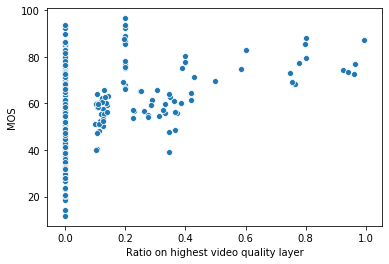

In [10]:
full["Ratio on highest video quality layer"] = np.nan

for index, row in full.iterrows():
    value = maxRatio(row['dash_bitrate'], 7000, row['duration'], row['initial buffer time'])
    full.at[index, 'Ratio on highest video quality layer'] = value
sns.scatterplot(y="MOS", x="Ratio on highest video quality layer", ci=None, data=full)
print(spearmanr(full['MOS'], full['Ratio on highest video quality layer']))

## Spearman rang corr. coeff. and Video rendering ratio on different h.264 levels
Let's plot on the graph with the correlation levels, depending on how  which quality level it is rendered.

In [11]:
full["Ratio on video quality layers_tests"] = np.nan
spearman_dash_levels = []
for level in dash_list:
    for index, row in full.iterrows():
        value = maxRatio(row['dash_bitrate'], level, row['duration'], row['initial buffer time'])
        full.at[index, 'Ratio on video quality layers_tests'] = value
    sp = spearmanr(full['MOS'], full['Ratio on video quality layers_tests'])
    spearman_dash_levels.append([sp[0], sp[1],level])

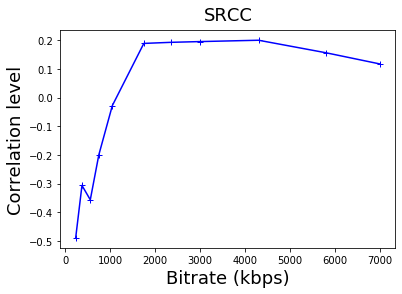

In [12]:
spearman_dash_levels = np.array(spearman_dash_levels)
fig, ax = plt.subplots()
x = list(spearman_dash_levels[:,2])
y = spearman_dash_levels[:,0]
ax.plot(x, y, 'b+', linestyle='solid')
ax.set_title("SRCC", fontsize=18, verticalalignment='bottom')
ax.set_ylabel('Correlation level', fontsize=18)
ax.set_xlabel('Bitrate (kbps)', fontsize=18)
plt.show()

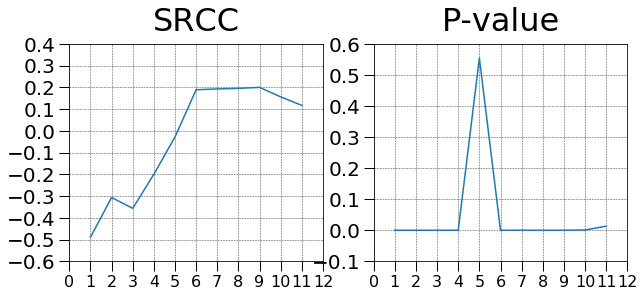

In [13]:
# First create some toy data:
x = np.arange(1, 12, 1)

#plt.style.use('grayscale')

def minor_tick(x, pos):
    if not x % 1.0:
        return ""
    return "%.2f" % x

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(10, 4))
ax1.plot(x, spearman_dash_levels[:,0])
#ax1.set_title('SRCC')
#ax2.set_title('p-value')

ax1.set_title("SRCC", fontsize=32, verticalalignment='bottom')
ax2.set_title("P-value", fontsize=32, verticalalignment='bottom')

ax1.xaxis.set_major_locator(MultipleLocator(1.000))
ax1.xaxis.set_minor_locator(AutoMinorLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(.1000))
ax1.yaxis.set_minor_locator(AutoMinorLocator(1))
ax1.xaxis.set_minor_formatter(FuncFormatter(minor_tick))

ax1.set_xlim(0, 12)
ax1.set_ylim(-0.6, 0.4)

ax1.tick_params(which='major', width=1.0)
ax1.tick_params(which='major', length=10)
ax1.tick_params(which='minor', width=1.0, labelsize=10)
ax1.tick_params(which='minor', length=5, labelsize=10, labelcolor='0.25')

#plt.imshow(cmap="Greys")

ax1.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)

ax2.xaxis.set_major_locator(MultipleLocator(1.000))
ax2.xaxis.set_minor_locator(AutoMinorLocator(1))
ax2.yaxis.set_major_locator(MultipleLocator(.1000))
ax2.yaxis.set_minor_locator(AutoMinorLocator(1))
ax2.xaxis.set_minor_formatter(FuncFormatter(minor_tick))

ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=20)

ax2.tick_params(axis="x", labelsize=16)
ax2.tick_params(axis="y", labelsize=20)

ax2.set_xlim(0, 12)
ax2.set_ylim(-0.1, 0.6)

ax2.tick_params(which='major', width=1.0)
ax2.tick_params(which='major', length=10)
ax2.tick_params(which='minor', width=1.0, labelsize=10)
ax2.tick_params(which='minor', length=5, labelsize=10, labelcolor='0.25')

ax2.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)
ax2.plot(x, spearman_dash_levels[:,1])

An interesting picture turns out. The level of correlation at quality levels 6-9 is approximately the same, then it decreases slightly.
And as you can see, the worst quality reproduction affects perception the most. The decrease at levels 10-11 can be explained by an increase in the number of negative factors (re-buffering, for example)

The peak in the level of statistical significance can be explained by the fact that playing at the average quality level does not affect the score in any way.

Let's enter a **rendering rate at a quality level of more than half of the maximum**.
Strictly speaking, it can depend on the division into quality levels.
Nevertheless, such an indicator must be taken into account.

**0.76** is better than **0.17**, isn't it?

SpearmanrResult(correlation=0.7586086365859753, pvalue=2.2024195942558703e-85)
KendalltauResult(correlation=0.5806230974894397, pvalue=2.3449788334268887e-72)


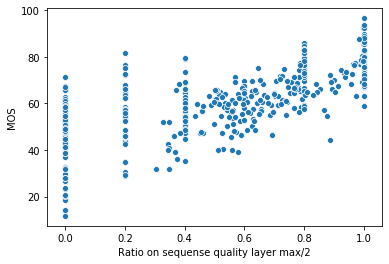

In [14]:
def Ph_dash_2(bitrates, duration, inbuf):
    bitrates = [int(item) for item in bitrates]
    max_bitrate = max (bitrates)
    hqd6 = bitrates.count(1750)
    hqd7 = bitrates.count(2350)
    hqd8 = bitrates.count(3000)
    hqd9 = bitrates.count(4300)
    hqd10 = bitrates.count(5800)
    hqd11 = bitrates.count(7000)
    
    hqd = hqd6 + hqd7 + hqd8 + hqd9 + hqd10 + hqd11
    ph = 2*hqd / (duration-inbuf)
    
    return ph

full["Ratio on sequense quality layer max/2"] = np.nan
for index, row in full.iterrows():
    value = Ph_dash_2(row['dash_bitrate'], row['duration'], row['initial buffer time'])
    full.at[index, 'Ratio on sequense quality layer max/2'] = value

ax = sns.scatterplot(y="MOS", x="Ratio on sequense quality layer max/2", ci=None, data=full)
print(spearmanr(full['MOS'], full['Ratio on sequense quality layer max/2']))
print(kendalltau(full['MOS'], full['Ratio on sequense quality layer max/2']))

## Constant Bitrate
You might have noticed that in some sessions the bitrate did not change. Let's check how many of them are in terms of quality levels and in the actually fixed bitrate.
In both cases, there are 54 of 450. Quite a lot.

In [15]:
count=0
for index, row in full.iterrows():
    value = (row['bitrates'])
    if (sum(abs(np.diff(value)))==0):
        count += 1
count

54

In [16]:
count=0
const_bitrates=[]
mos_const_bitrates = []
for index, row in full.iterrows():
    bitrates = [int(item) for item in row['dash_bitrate']]
    if (sum(abs(np.diff(bitrates)))==0):
        count += 1
        const_bitrates.append (bitrates[0])
        mos_const_bitrates.append (row['MOS'])
count

54

How do you like this level of correlation? **0.86!** Let's introduce the **bitrate constancy sign**.

SpearmanrResult(correlation=0.8557424141365629, pvalue=1.681430171097886e-16)
KendalltauResult(correlation=0.7128190293720237, pvalue=6.983483322670256e-13)


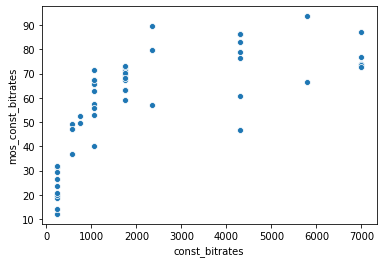

In [17]:
data_tuples = list(zip(const_bitrates,mos_const_bitrates))
test = pd.DataFrame(data_tuples, columns=['const_bitrates','mos_const_bitrates'])

ax = sns.scatterplot(x= "const_bitrates", y= "mos_const_bitrates", ci="sd", data = test)
print(spearmanr(const_bitrates, mos_const_bitrates))
print(kendalltau(const_bitrates, mos_const_bitrates))

In [18]:
full["Constant_bitrate"] = 0
for index, row in full.iterrows():
    bitrates = [int(item) for item in row['dash_bitrate']]
    #value = (row['dash_bitrate'])
    
    if (sum(abs(np.diff(bitrates)))==0):
        full.at[index, 'Constant_bitrate'] = 1

# Data cleaning, removal of highly cross-correlated features
We will calculate spearman's correlation
p-value means significence of the feature. Te lower the better.
p-value must be less than 0.05

In [19]:
full.columns

Index(['Name', 'FPS', 'stallTime', 'duration', 'switching',
       'SwithcingMagnitide', 'bitrates', 'seqPSNR per frame',
       'initial buffer time', 'duration of stalling events in second',
       'Rebuffer count', 'average duration of stalling event', 'mean(seqPSNR)',
       'MOS', 'Representation 1', 'Representation 2', 'Representation 3',
       'Representation 4', 'Representation 5', 'averageWeightedBitrate', 'SI',
       'TI', 'content', 'motion', 'st_events_median',
       'SwithcingMagnitide_median', 'st_events_max', 'SwithcingMagnitide_max',
       'median(PSNR)', 'width', 'heigth', 'dash_bitrate',
       'median(dash_bitrate)', 'mean(width)', 'mean(heigth)',
       'bitrate_pos_changes_count', 'bitrate_neg_changes_count',
       'bitrate_max_pos_change', 'bitrate_max_neg_change',
       'bitrate_mean_pos_change', 'bitrate_mean_neg_change', 'freq_of_st',
       'Bitrate switch count', 'freq_of_sw', 'median(bitrates)',
       'Rebuffer percentage', 'dash_change_count',
      

In [20]:
data = full.copy()

In [21]:
data = data.drop('Representation 1', axis = 1)
data = data.drop('Representation 2', axis = 1)
data = data.drop('Representation 3', axis = 1)
data = data.drop('Representation 4', axis = 1)
data = data.drop('Representation 5', axis = 1)

data = data.drop('Name', axis = 1)
data = data.drop('FPS', axis = 1)
data = data.drop('switching', axis = 1)
data = data.drop('SwithcingMagnitide', axis = 1)
data = data.drop('bitrates', axis = 1)

data = data.drop('seqPSNR per frame', axis = 1)
data = data.drop('duration of stalling events in second', axis = 1)

data = data.drop('SwithcingMagnitide_median', axis = 1)#Потому что я не понимаю, что это
data = data.drop('SwithcingMagnitide_max', axis = 1)#Потому что я не понимаю, что это

data = data.drop('width', axis = 1)
data = data.drop('heigth', axis = 1)
data = data.drop('dash_bitrate', axis = 1)

data = data.drop('Ratio on video quality layers_tests', axis = 1)

In [22]:
cols = data.columns
cols = [cols [6]] + [cols [:6]] + [cols [7:]]
mos = data['MOS']
data.drop(labels=['MOS'], axis=1,inplace = True)
data.insert(0, 'MOS', mos)

# Heat map

Some researchers note that **Kendall correlation coefficient** is more accurate that Spearman in terms of Average Variation and more robust.

But, 1) In the present study, this is fundamentally unimportant. This can change, for example, the choice of the median or mean value of the characteristic.

2) We still using SRCC in case of comparison with other papers


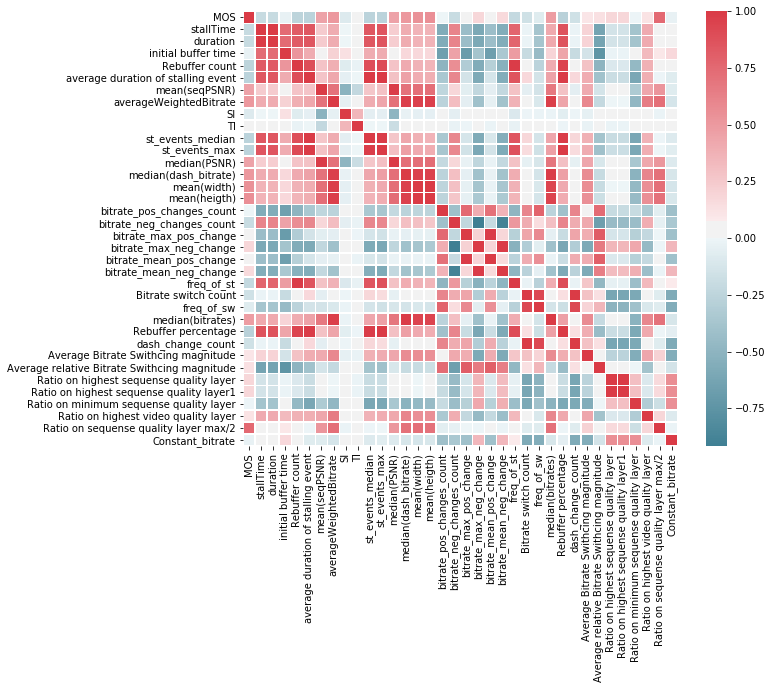

In [23]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr(method="spearman")
#corr = data.corr(method="kendall")
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, linewidths=.5)

## Clean the data
Next, we select and remove features, leaving those that have a higher association with MOS

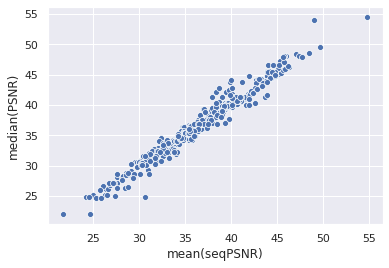

In [24]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(x="mean(seqPSNR)", y="median(PSNR)", ci=None, data=data)

In [25]:
print(spearmanr(full['MOS'], full['mean(seqPSNR)']))
print(spearmanr(full['MOS'], full['median(PSNR)']))
print(kendalltau(full['MOS'], full['mean(seqPSNR)']))
print(kendalltau(full['MOS'], full['median(PSNR)']))

SpearmanrResult(correlation=0.4605696129707933, pvalue=5.197174527829186e-25)
SpearmanrResult(correlation=0.4584182988053739, pvalue=9.15303807725632e-25)
KendalltauResult(correlation=0.3157076752829798, pvalue=1.4329786849029477e-23)
KendalltauResult(correlation=0.31307204319452325, pvalue=3.4975533679087155e-23)


In [26]:
data = data.drop('median(PSNR)', axis = 1)

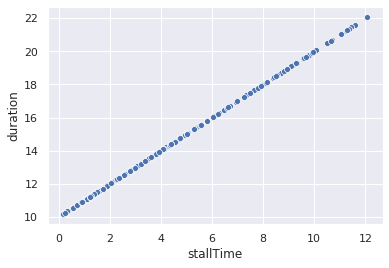

In [27]:
sns.scatterplot(x="stallTime", y="duration", ci=None, data=data)

In [28]:
data = data.drop('duration', axis = 1)

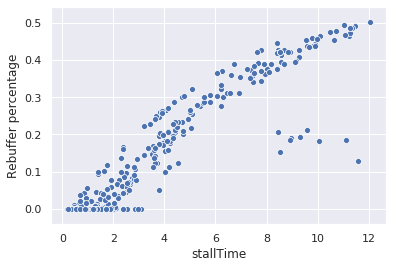

In [29]:
sns.scatterplot(x="stallTime", y="Rebuffer percentage", ci=None, data=data)

In [30]:
print(kendalltau(full['stallTime'], full['Rebuffer percentage']))

KendalltauResult(correlation=0.7382759208452032, pvalue=1.6983314242553445e-103)


In [31]:
print("Sp MOS vs stallTime", spearmanr(full['MOS'], full['stallTime']))
print("Sp MOS vs Rebuffer percentage",spearmanr(full['MOS'], full['Rebuffer percentage']))
print("Ken MOS vs stallTime", kendalltau(full['MOS'], full['stallTime']))
print("Ken MOS vs Rebuffer percentage",kendalltau(full['MOS'], full['Rebuffer percentage']))

Sp MOS vs stallTime SpearmanrResult(correlation=-0.20124679789462296, pvalue=1.697985539817566e-05)
Sp MOS vs Rebuffer percentage SpearmanrResult(correlation=-0.27325064979898134, pvalue=3.794375770804499e-09)
Ken MOS vs stallTime KendalltauResult(correlation=-0.1457147198774841, pvalue=4.114137829849412e-06)
Ken MOS vs Rebuffer percentage KendalltauResult(correlation=-0.21353146136334783, pvalue=3.7059899570408545e-10)


In [32]:
data = data.drop('stallTime', axis = 1)

## We derive the correlation and p-value for paired features 

But it works only with numerical data. Let's see at the categorical data

In [33]:
corr['MOS'].sort_values(ascending=False )

MOS                                             1.000000
Ratio on sequense quality layer max/2           0.758609
mean(heigth)                                    0.558450
mean(width)                                     0.541159
averageWeightedBitrate                          0.511754
median(dash_bitrate)                            0.508260
median(bitrates)                                0.481514
mean(seqPSNR)                                   0.460570
median(PSNR)                                    0.458418
Ratio on highest sequense quality layer1        0.177574
Ratio on highest sequense quality layer         0.177574
bitrate_max_neg_change                          0.177276
bitrate_mean_neg_change                         0.167193
Average relative Bitrate Swithcing magnitude    0.133380
Ratio on highest video quality layer            0.117148
Average Bitrate Swithcing magnitude             0.108230
bitrate_mean_pos_change                         0.072694
TI                             

## Density plots and feature deropping
Let's take a look at how traffic and content type data is distributed.
Next, let's look at the signs that correlate well with each other and remove those that correlate worse with MOS. 

In [34]:
types = data['motion'].copy()
types = types.value_counts()
print (types)
types = list(types.index)

print (types)

smooth motion     190
high motion       128
average motion     92
static             30
camera motion      10
Name: motion, dtype: int64
['smooth motion', 'high motion', 'average motion', 'static', 'camera motion']


[None, None, None, None, None, None, None, None, None, None]

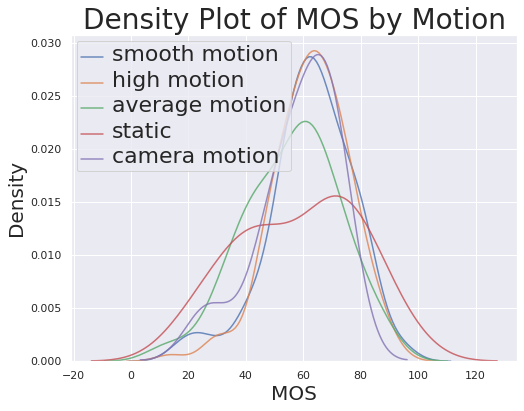

In [35]:
figsize(8, 6)

# Plot each type of motion
for b_type in types:
    # Select the motion type
    subset = full[full['motion'] == b_type]
    #print (subset)
    
    # Density plot
    ax = sns.kdeplot(subset['MOS'],
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('MOS', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of MOS by Motion', size = 28);
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text

### Motion
It is quite clear and confirmed by many researchers that the amount of movement affects both the quality of encoding / decoding and perception.

But in the data under consideration, human estimates are practically the same. Only static motion and average motion differ, others type look the same.

[None, None, None, None, None, None, None, None, None, None]

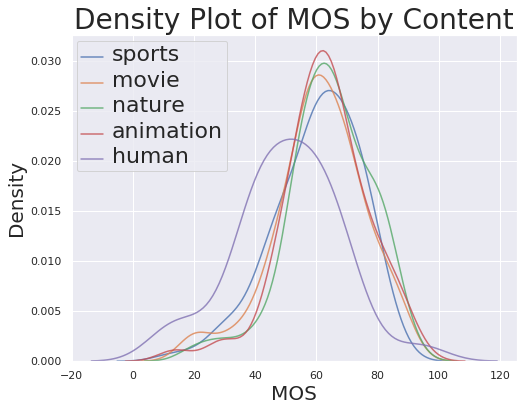

In [36]:
types = data.dropna(subset=['MOS'])
types = types['content'].value_counts()
types = list(types.index)
figsize(8, 6)
for b_type in types[0:5]:
    # Select the content type
    subset = data[data['content'] == b_type]
    #print (subset)
    
    # Density plot
    ax = sns.kdeplot(subset['MOS'],
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('MOS', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of MOS by Content', size = 28);
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text

[None, None, None, None, None, None, None, None, None, None, None, None]

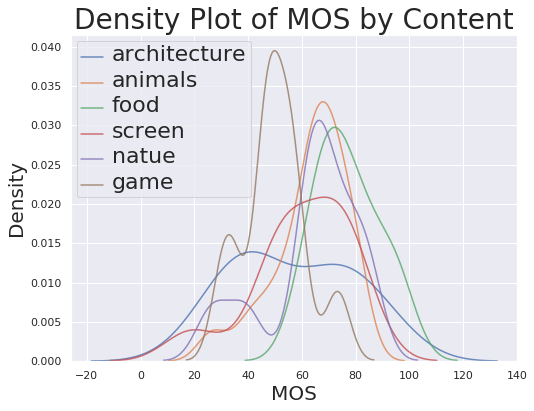

In [37]:
figsize(8, 6)

for b_type in types[5:]:
    # Select the content type
    subset = data[data['content'] == b_type]
    #print (subset)
    
    # Density plot
    ax = sns.kdeplot(subset['MOS'],
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('MOS', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of MOS by Content', size = 28);
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text

### Content

I've split the content into two graphs to make it clearer. There are noticeably different probability distributions, but at the same time, there are almost completely identical ones.

What conclusion can be drawn.

As shown below, neither spatial and temporal information nor these categorical human estimates are reliable estimates in terms of level of correlation and statistical significance.

Coinciding probability distributions indicate that these features are the same for the model. That is, **these estimates are invalid**.

In [38]:
data.to_pickle("Part2_tmp")

## Next

In the next section, we will finalize data cleansing in terms of cross-correlations and perform analysis using machine learning.

In [39]:
data

,MOS,initial buffer time,Rebuffer count,average duration of stalling event,mean(seqPSNR),averageWeightedBitrate,SI,TI,content,motion,...,Rebuffer percentage,dash_change_count,Average Bitrate Swithcing magnitude,Average relative Bitrate Swithcing magnitude,Ratio on highest sequense quality layer,Ratio on highest sequense quality layer1,Ratio on minimum sequense quality layer,Ratio on highest video quality layer,Ratio on sequense quality layer max/2,Constant_bitrate
0,31.376990,1.80000,3,0.74444,27.5826,222.0,96.0,97.0,animation,high motion,...,0.182559,0.0,0.000000,0.000000,0.817441,0.817441,0.817441,0.000000,0.000000,1
1,51.006205,0.53333,0,0.00000,29.5138,527.6,96.0,97.0,animation,high motion,...,0.000000,3.0,250.666667,250.666667,0.200001,0.200001,0.400001,0.000000,0.000000,0
2,48.948009,0.70000,0,0.00000,31.7743,1186.8,96.0,97.0,animation,high motion,...,0.000000,3.0,820.000000,820.000000,0.200000,0.200000,0.400000,0.000000,0.400000,0
3,58.343500,0.26667,0,0.00000,31.0625,1014.8,96.0,97.0,animation,high motion,...,0.000000,2.0,1230.000000,1230.000000,0.199999,0.199999,0.399999,0.000000,0.199999,0
4,62.817322,0.20000,0,0.00000,31.2189,1140.0,96.0,97.0,animation,high motion,...,0.000000,3.0,820.000000,820.000000,0.200000,0.200000,0.400000,0.000000,0.400000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,54.483469,1.92000,1,0.44000,28.0620,573.0,97.0,89.0,animation,high motion,...,0.042146,1.0,185.000000,-185.000000,0.191571,0.191571,0.766284,0.000000,0.000000,0
446,76.445037,0.76000,1,0.16000,31.7082,1588.6,97.0,89.0,animation,high motion,...,0.015748,2.0,759.000000,759.000000,0.196850,0.196850,0.196850,0.000000,0.787402,0
447,72.682050,1.20000,0,0.00000,30.3363,1134.6,97.0,89.0,animation,high motion,...,0.000000,1.0,658.000000,658.000000,0.200000,0.200000,0.800000,0.000000,0.200000,0
448,59.808226,2.28000,4,2.09000,35.9435,4297.8,97.0,89.0,animation,high motion,...,0.455338,4.0,1116.500000,-1116.500000,0.108932,0.108932,0.108932,0.108932,0.544662,0
